In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.linalg import cholesky

In [58]:
'''
state estimation
x(k+1) = sqrt(5+x(k)) + w(k)
y(k) = x(k)^3 + v(k)
'''

SigmaW = 1 # Process noise covariance
SigmaV = 2 # Sensor noise covariance
maxIter = 40


# Define size of variables in model
Nx = 1     # state  = 1x1 scalar
Nxa = 3    # augmented state has also w(k) and v(k) contributions
Nz = 1     # output = 1x1 scalar

# constants for the SPKF algorithm. 
Wmx = np.zeros(2*Nxa+1)
h = np.sqrt(3)
Wmx[0] = (h**2-Nxa)/(h**2)
Wmx[1:] = 1/(2*h**2) 
Wcx=Wmx

xtrue = 2 + np.random.rand(1)   # Initialize true system initial state
xhat = np.array(2)                        # Initialize Kalman filter initial estimate
SigmaX = 1                      # Initialize Kalman filter covariance
u = 0                           # Unknown initial driving input: assume zero

# % Reserve storage for variables we might want to plot/evaluate
xstore = [xtrue.item()]
xhatstore = []
SigmaXstore = []

for k in range(maxIter):
    # SPKF Step 1: State estimate time update
    # 1a: Calculate augmented state estimate, including ...
    xhata = np.array([xhat.item(), 0, 0])  # process and sensor noise mean
    # 1b: Get desired Cholesky factor
    Pxa = block_diag(SigmaX,SigmaW,SigmaV)
    sPxa = cholesky(Pxa, lower=True)    
    # 1c: Calculate sigma points (strange indexing of xhat to avoid
    X = xhata.reshape(3,1) + h*np.hstack([np.zeros((Nxa, 1)), sPxa, -sPxa])
    # 1d: Calculate state equation for every element
    Xx = np.sqrt(5+X[0,:]) + X[1,:]
    xhat = Wmx@Xx
    
    # SPKF Step 2: Covariance of prediction
    SigmaX = Wcx@(Xx - xhat)**2

    # mean and standard deviation
    w = np.random.normal(0, np.sqrt(SigmaW), 1) 
    v = np.random.normal(0, np.sqrt(SigmaV), 1)
    ytrue = xtrue**3 + v
    xtrue = np.sqrt(5+xtrue) + w

    # SPKF Step 3: Create output estimate
    Y = Xx**3 + X[2,:];
    yhat = Wcx@Y

    # SPKF Step 4: Estimator gain matrix
    SigmaXY = Wcx@((Xx - xhat)*(Y - yhat))
    SigmaY  = Wcx@(Y - yhat)**2
    L = SigmaXY/SigmaY
    
    # SPKF Step 5: Measurement state update
    xhat = xhat + L*(ytrue - yhat)
    
    # SPKF Step 6: Measurement covariance update
    SigmaX = SigmaX - L*SigmaY*L.T
    
    # store information
    xstore.append(xtrue.item())
    xhatstore.append(xhat.item())
    SigmaXstore.append(SigmaX.item())

xstore = np.array(xstore)
xhatstore = np.array(xhatstore)
SigmaXstore = np.array(SigmaXstore)

Text(0, 0.5, 'Estimation Error')

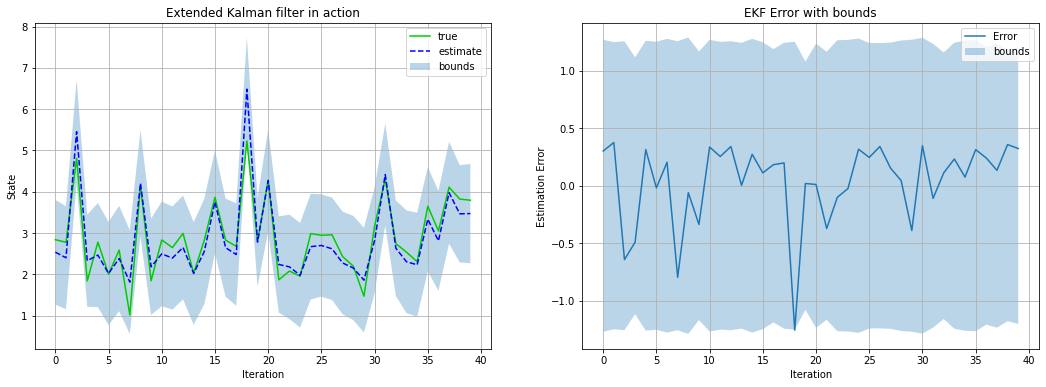

In [59]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(np.arange(maxIter),xstore[:maxIter],color=(0,0.8,0))
plt.plot(np.arange(maxIter),xhatstore,color=(0,0,1),linestyle='dashed')
plt.fill_between(np.arange(maxIter), xhatstore+3*np.sqrt(SigmaXstore), xhatstore-3*np.sqrt(SigmaXstore), alpha=0.3)
plt.grid()
plt.legend(['true','estimate','bounds'])
plt.title('Extended Kalman filter in action')
plt.xlabel('Iteration')
plt.ylabel('State')

plt.subplot(1,2,2)
estErr = xstore[:maxIter]-xhatstore 
bounds = 3*np.sqrt(SigmaXstore)
plt.plot(np.arange(maxIter), estErr)
plt.fill_between(np.arange(maxIter), bounds, -bounds, alpha=0.3)
plt.grid()
plt.legend(['Error','bounds'])
plt.title('EKF Error with bounds')
plt.xlabel('Iteration') 
plt.ylabel('Estimation Error')

In [39]:
# Compute rms error
np.sqrt(np.mean(estErr**2))

0.3049069992819216

In [21]:
# Compute fraction of estimates outside of 3-sigma bounds
sum(abs(estErr)>bounds)/maxIter

0.0

In [22]:
np.min(abs(estErr))

0.0042190986275345566